In [1]:
import numpy as np
import os
import pandas as pd
from skimage import io, transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from torchvision import transforms, utils
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device('cuda')

trial = "_1_"

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=5, zero_init_residual=False,
                 groups=1, width_per_group=64, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [ ]:
def ResNet18(pretrained=False):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

def ResNet50(pretrained=False):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3])
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

In [ ]:
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    
class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode):
        """
        Args:
            root (string): Root path of the dataset.
            mode : Indicate procedure status(training or testing)

            self.img_name (string list): String list that store all image names.
            self.label (int or float list): Numerical list that store all ground truth label values.
        """
        self.root = root
        self.img_name, self.label = getData(mode)
        self.mode = mode
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        """something you should implement here"""

        """
           step1. Get the image path from 'self.img_name' and load it.
                  hint : path = root + self.img_name[index] + '.jpeg'
           
           step2. Get the ground truth label from self.label
                     
           step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                  rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 
                       
                  In the testing phase, if you have a normalization process during the training phase, you only need 
                  to normalize the data. 
                  
                  hints : Convert the pixel value to [0, 1]
                          Transpose the image shape from [H, W, C] to [C, H, W]
                         
            step4. Return processed image and label
        """
        
        img_name = os.path.join(self.root,self.img_name[index]+'.jpeg')
        img = io.imread(img_name)
        
        label = torch.from_numpy(self.label)[index]
        
        if self.mode == 'train':
            data_transform = transforms.Compose([
                # transforms.RandomSizedCrop(224),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor()])
        else:
            data_transform = transforms.Compose([
                transforms.ToTensor()])
        
        img = data_transform(img)

        return img, label

In [ ]:
train_dataset = RetinopathyLoader("./data/", "train")
test_dataset = RetinopathyLoader("./data/", "test")

In [2]:
def train(epoch):
    net.train()
    adjust_learning_rate(optimizer, epoch)
    correct = 0
    train_loss = 0
    
    running_loss = 0.0
    for it, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device=device, dtype=torch.float), labels.to(device=device)
        
        # clean up the parameter gradients
        optimizer.zero_grad()
        
        # forward, backward, optimize
        output = net(inputs)
        labels = labels.long()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(labels.data).cpu().sum()
        loss = loss_f(output, labels)
        train_loss += loss.data
        loss.backward()
        optimizer.step()
    train_loss = train_loss
    train_loss /= 28099 # loss function already averages over batch size
    print('Training set: Average loss: {:.4f}, Accuracy: {}/{} ({}%)'.format(\
    train_loss, correct, 28099, 100. * correct / float(28099)))
    
    return correct

In [3]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    
    for it, (inputs, labels) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device=device, dtype=torch.float), labels.to(device=device)
        
        with torch.no_grad():
            output = net(inputs)
        labels = labels.long()
        test_loss += loss_f(output, labels).data
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(labels.data).cpu().sum()
    
    test_loss = test_loss
    test_loss /= 7025 # loss function already averages over batch size
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(\
        test_loss, correct, 7025, 100. * float(correct) / 7025))
    acc = str(round(100. * float(correct) / 7025))
    
    filename = './model/'+net_name+trial+str(epoch)+"_"+acc+".pth"
    torch.save(net, filename)
    
    return correct

# Resnet 18 without pre-trained 

In [ ]:
net = ResNet18()
net_name = "res18"
net.to(device)

In [ ]:
BATCH_SIZE = 48
LR = 1e-3
epochs = 10
optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=0.9)
loss_f = nn.CrossEntropyLoss()

In [ ]:
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
training_acc = {'acc':[]}
testing_acc = {'acc':[]}
for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    tr_acc = train(epoch)
    training_acc['acc'].append((float(tr_acc)/28099))
    te_acc = test(epoch)
    testing_acc['acc'].append((float(te_acc)/7025))

In [ ]:
import yaml

with open("./output/"+net_name+"_train.yaml", 'w') as outfile:
    yaml.dump(training_acc, outfile, default_flow_style=False)
with open("./output/"+net_name+"_test.yaml", 'w') as outfile:
    yaml.dump(testing_acc, outfile, default_flow_style=False)

# Resnet 50 without pre-trained  

In [ ]:
net = ResNet50()
net_name = "res50"
net.to(device)

In [ ]:
BATCH_SIZE = 10
LR = 1e-3
epochs = 5
optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=0.9)
loss_f = nn.CrossEntropyLoss()

In [ ]:
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
training_acc = {'acc':[]}
testing_acc = {'acc':[]}
for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    tr_acc = train(epoch)
    training_acc['acc'].append((float(tr_acc)/28099))
    te_acc = test(epoch)
    testing_acc['acc'].append((float(te_acc)/7025))

In [ ]:
import yaml

with open("./output/"+net_name+"_train.yaml", 'w') as outfile:
    yaml.dump(training_acc, outfile, default_flow_style=False)
with open("./output/"+net_name+"_test.yaml", 'w') as outfile:
    yaml.dump(testing_acc, outfile, default_flow_style=False)

# Pre-trained Model 

In [12]:
import torchvision.models as models
from PIL import Image

In [3]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18_pre":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 512
    elif model_name == "resnet50_pre":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 512

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [6]:
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    
class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode):
        """
        Args:
            root (string): Root path of the dataset.
            mode : Indicate procedure status(training or testing)

            self.img_name (string list): String list that store all image names.
            self.label (int or float list): Numerical list that store all ground truth label values.
        """
        self.root = root
        self.img_name, self.label = getData(mode)
        self.mode = mode
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        """something you should implement here"""

        """
           step1. Get the image path from 'self.img_name' and load it.
                  hint : path = root + self.img_name[index] + '.jpeg'
           
           step2. Get the ground truth label from self.label
                     
           step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                  rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 
                       
                  In the testing phase, if you have a normalization process during the training phase, you only need 
                  to normalize the data. 
                  
                  hints : Convert the pixel value to [0, 1]
                          Transpose the image shape from [H, W, C] to [C, H, W]
                         
            step4. Return processed image and label
        """
        
        img_name = os.path.join(self.root,self.img_name[index]+'.jpeg')
        img = Image.open(img_name).convert('RGB')
        
        label = torch.from_numpy(self.label)[index]
        
        if self.mode == 'train':
            data_transform = transforms.Compose([
                transforms.Resize(input_size),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(), 
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        else:
            data_transform = transforms.Compose([
                transforms.Resize(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
        img = data_transform(img)

        return img, label

In [7]:
def adjust_learning_rate(optimizer, epoch):
    if epoch < 20:
       lr = 1e-3
    else:
       lr = 1e-4

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# ResNet 18 Pre-trained Model 

In [8]:
net_name = "resnet18_pre"
net, input_size = initialize_model(net_name, 5, True, use_pretrained=True)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [9]:
train_dataset = RetinopathyLoader("./data/", "train")
test_dataset = RetinopathyLoader("./data/", "test")

> Found 28099 images...
> Found 7025 images...


In [10]:
BATCH_SIZE = 48
LR = 1e-3
epochs = 70
optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
loss_f = nn.CrossEntropyLoss()

In [11]:
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [12]:
training_acc = {'acc':[]}
testing_acc = {'acc':[]}
for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    tr_acc = train(epoch)
    training_acc['acc'].append((float(tr_acc)/28099))
    te_acc = test(epoch)
    testing_acc['acc'].append((float(te_acc)/7025))

Epoch:  1
Training set: Average loss: 0.0176, Accuracy: 20553/28099 (73%)
Test set: Average loss: 0.0165, Accuracy: 5168/7025 (73.57%)

Epoch:  2
Training set: Average loss: 0.0164, Accuracy: 20762/28099 (73%)
Test set: Average loss: 0.0161, Accuracy: 5199/7025 (74.01%)

Epoch:  3
Training set: Average loss: 0.0161, Accuracy: 20806/28099 (74%)
Test set: Average loss: 0.0159, Accuracy: 5219/7025 (74.29%)

Epoch:  4
Training set: Average loss: 0.0159, Accuracy: 20873/28099 (74%)
Test set: Average loss: 0.0158, Accuracy: 5237/7025 (74.55%)

Epoch:  5
Training set: Average loss: 0.0158, Accuracy: 20920/28099 (74%)
Test set: Average loss: 0.0157, Accuracy: 5248/7025 (74.70%)

Epoch:  6
Training set: Average loss: 0.0157, Accuracy: 20994/28099 (74%)
Test set: Average loss: 0.0156, Accuracy: 5253/7025 (74.78%)

Epoch:  7
Training set: Average loss: 0.0156, Accuracy: 21009/28099 (74%)
Test set: Average loss: 0.0156, Accuracy: 5257/7025 (74.83%)

Epoch:  8
Training set: Average loss: 0.0156, Ac

Training set: Average loss: 0.0150, Accuracy: 21158/28099 (75%)
Test set: Average loss: 0.0153, Accuracy: 5298/7025 (75.42%)

Epoch:  62
Training set: Average loss: 0.0150, Accuracy: 21187/28099 (75%)
Test set: Average loss: 0.0153, Accuracy: 5299/7025 (75.43%)

Epoch:  63
Training set: Average loss: 0.0150, Accuracy: 21182/28099 (75%)
Test set: Average loss: 0.0153, Accuracy: 5299/7025 (75.43%)

Epoch:  64
Training set: Average loss: 0.0151, Accuracy: 21181/28099 (75%)
Test set: Average loss: 0.0152, Accuracy: 5302/7025 (75.47%)

Epoch:  65
Training set: Average loss: 0.0150, Accuracy: 21192/28099 (75%)
Test set: Average loss: 0.0153, Accuracy: 5298/7025 (75.42%)

Epoch:  66
Training set: Average loss: 0.0150, Accuracy: 21187/28099 (75%)
Test set: Average loss: 0.0153, Accuracy: 5299/7025 (75.43%)

Epoch:  67
Training set: Average loss: 0.0150, Accuracy: 21188/28099 (75%)
Test set: Average loss: 0.0153, Accuracy: 5301/7025 (75.46%)

Epoch:  68
Training set: Average loss: 0.0150, Accur

In [13]:
import yaml

with open("./output/"+net_name+"_train.yaml", 'w') as outfile:
    yaml.dump(training_acc, outfile, default_flow_style=False)
with open("./output/"+net_name+"_test.yaml", 'w') as outfile:
    yaml.dump(testing_acc, outfile, default_flow_style=False)

In [ ]:
training_acc = {'acc':[]}
testing_acc = {'acc':[]}
for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    tr_acc = train(epoch)
    training_acc['acc'].append((float(tr_acc)/28099))
    te_acc = test(epoch)
    testing_acc['acc'].append((float(te_acc)/7025))

Epoch:  1
Training set: Average loss: 0.0175, Accuracy: 20583/28099 (73%)
Test set: Average loss: 0.0165, Accuracy: 5165/7025 (73.52%)

Epoch:  2
Training set: Average loss: 0.0164, Accuracy: 20718/28099 (73%)
Test set: Average loss: 0.0161, Accuracy: 5194/7025 (73.94%)

Epoch:  3
Training set: Average loss: 0.0161, Accuracy: 20826/28099 (74%)
Test set: Average loss: 0.0159, Accuracy: 5215/7025 (74.23%)

Epoch:  4
Training set: Average loss: 0.0159, Accuracy: 20852/28099 (74%)
Test set: Average loss: 0.0158, Accuracy: 5229/7025 (74.43%)

Epoch:  5
Training set: Average loss: 0.0158, Accuracy: 20913/28099 (74%)
Test set: Average loss: 0.0157, Accuracy: 5239/7025 (74.58%)

Epoch:  6
Training set: Average loss: 0.0157, Accuracy: 20956/28099 (74%)
Test set: Average loss: 0.0156, Accuracy: 5247/7025 (74.69%)

Epoch:  7
Training set: Average loss: 0.0156, Accuracy: 20978/28099 (74%)
Test set: Average loss: 0.0156, Accuracy: 5250/7025 (74.73%)

Epoch:  8
Training set: Average loss: 0.0156, Ac

In [ ]:
import yaml

with open("./output/"+net_name+"_train.yaml", 'w') as outfile:
    yaml.dump(training_acc, outfile, default_flow_style=False)
with open("./output/"+net_name+"_test.yaml", 'w') as outfile:
    yaml.dump(testing_acc, outfile, default_flow_style=False)

# ResNet 50 Pre-trained Model

In [ ]:
net_name = "resnet50_pre"
net, input_size = initialize_model(net_name, 5, True, use_pretrained=True)
net.to(device)

In [ ]:
train_dataset = RetinopathyLoader("./data/", "train")
test_dataset = RetinopathyLoader("./data/", "test")

In [ ]:
BATCH_SIZE = 10
LR = 1e-3
epochs = 20
optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=0.9)
loss_f = nn.CrossEntropyLoss()

In [ ]:
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
#training_acc = {'acc':[]}
#testing_acc = {'acc':[]}
for epoch in range(6, epochs + 1):
    print("Epoch: ", epoch)
    tr_acc = train(epoch)
    training_acc['acc'].append((float(tr_acc)/28099))
    te_acc = test(epoch)
    testing_acc['acc'].append((float(te_acc)/7025))

In [ ]:
import yaml

with open("./output/"+net_name+"_train.yaml", 'w') as outfile:
    yaml.dump(training_acc, outfile, default_flow_style=False)
with open("./output/"+net_name+"_test.yaml", 'w') as outfile:
    yaml.dump(testing_acc, outfile, default_flow_style=False)

# Test 

In [7]:
def only_test():
    net.eval()
    test_loss = 0
    correct = 0
    
    y_test = np.array([])
    y_pred = np.array([])
    
    for it, (inputs, labels) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device=device, dtype=torch.float), labels.to(device=device)
        
        with torch.no_grad():
            output = net(inputs)
        labels = labels.long()
        test_loss += loss_f(output, labels).data
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(labels.data).cpu().sum()
        
        y_test = np.append(y_test, labels.cpu().numpy())
        y_pred = np.append(y_pred, pred.cpu().numpy())
    
    test_loss = test_loss
    test_loss /= 7025 # loss function already averages over batch size
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(\
        test_loss, correct, 7025, 100. * float(correct) / 7025))
    acc = str(round(100. * float(correct) / 7025))
    
    return y_test, y_pred

In [8]:
# net_name = "resnet18_pre"
# net, input_size = initialize_model(net_name, 5, True, use_pretrained=True)
net=torch.load("./model/resnet18_pre_1_67_75.pth")
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [14]:
BATCH_SIZE = 48
LR = 1e-3
input_size = 512
loss_f = nn.CrossEntropyLoss()

In [10]:
test_dataset = RetinopathyLoader("./data/", "test")
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

> Found 7025 images...


In [15]:
y_gt, y_pre = only_test()

Test set: Average loss: 0.0153, Accuracy: 5301/7025 (75.46%)



Confusion matrix, without normalization
[[5056    0   84    1   12]
 [ 474    0   11    1    2]
 [ 867    0  188   10   17]
 [  70    0   79   17    9]
 [  46    0   39    2   40]]
Normalized confusion matrix
[[9.81e-01 0.00e+00 1.63e-02 1.94e-04 2.33e-03]
 [9.71e-01 0.00e+00 2.25e-02 2.05e-03 4.10e-03]
 [8.01e-01 0.00e+00 1.74e-01 9.24e-03 1.57e-02]
 [4.00e-01 0.00e+00 4.51e-01 9.71e-02 5.14e-02]
 [3.62e-01 0.00e+00 3.07e-01 1.57e-02 3.15e-01]]


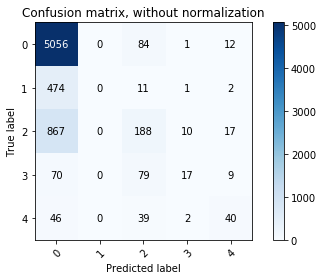

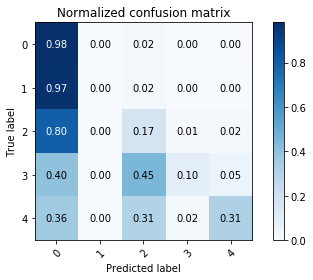

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# from sklearn import svm, datasets
# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred,
                         normalize=False,
                         title=None,
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['0','1','2','3','4']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          # ... and label them with the respective list entries
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_gt, y_pre,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_gt, y_pre, normalize=True,
                      title='Normalized confusion matrix')

plt.show()